<a href="https://colab.research.google.com/github/sejal1011/COVID-19-Detection-using-Chest-X-Ray/blob/main/Image_Processing_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/


In [ ]:
!pip install kaggle


In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 777M/778M [00:09<00:00, 142MB/s]
100% 778M/778M [00:09<00:00, 89.8MB/s]


In [ ]:
!unzip -q covid19-radiography-database.zip


In [ ]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [ ]:
import shutil

# Define paths
#drive_train_dir = '/content/drive/MyDrive/train'
drive_test_dir = '/content/drive/MyDrive/test'
#colab_train_dir = '/content/train'
colab_test_dir = '/content/test'

# Copy train folder
#shutil.copytree(drive_train_dir, colab_train_dir)

# Copy test folder
shutil.copytree(drive_test_dir, colab_test_dir)


'/content/test'

In [ ]:
print(os.listdir('/content/drive/MyDrive/test'))


['Viral Pneumonia', 'Normal', 'COVID']


In [ ]:
import os
from distutils.dir_util import copy_tree

# Source directory
directory = 'COVID-19_Radiography_Dataset'

# Source directories to copy
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']

# Destination directories
input_dir = './train'
output_dir = './test'

# Paths to individual class directories
normal_dir = os.path.join(directory, 'Normal')
viral_dir = os.path.join(directory, 'Viral Pneumonia')
covid_dir = os.path.join(directory, 'COVID')

# Check if the source directory exists
if os.path.isdir(directory):
    # Check if the 'train' directory exists, if not, create it
    if not os.path.isdir(input_dir):
        os.mkdir(input_dir)

        # Copy classes to the 'train' directory
        copy_tree(normal_dir, os.path.join(input_dir, 'Normal'))
        copy_tree(viral_dir, os.path.join(input_dir, 'Viral Pneumonia'))
        copy_tree(covid_dir, os.path.join(input_dir, 'COVID'))

        print("Training data copied successfully.")
    else:
        print("The 'train' directory already exists.")
else:
    print("Source directory does not exist.")


Training data copied successfully.


# New section

In [ ]:
import os

test_dir = '/content/test'
categories = ['Normal', 'Viral Pneumonia', 'COVID']

for category in categories:
    category_test_dir = os.path.join(test_dir, category)

    if os.path.exists(category_test_dir) and os.path.isdir(category_test_dir):
        images = [x for x in os.listdir(category_test_dir) if x.lower().endswith(('png', 'jpg', 'jpeg'))]

        # Check if there are more than 30 images
        if len(images) > 30:
            # Sort images by name to keep a consistent set
            images.sort()

            # Keep only the first 30 images
            images_to_keep = images[:30]

            # Remove the rest of the images
            for image in images:
                if image not in images_to_keep:
                    image_path = os.path.join(category_test_dir, image)
                    os.remove(image_path)
        else:
            print(f"Category {category} has {len(images)} images. Nothing to delete.")
    else:
        print(f"Category {category} not found in the test folder.")


Category Normal has 0 images. Nothing to delete.
Category Viral Pneumonia has 0 images. Nothing to delete.
Category COVID has 0 images. Nothing to delete.


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class ChestXRayDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.data_dirs = data_dirs
        self.transform = transform
        self.classes = list(self.data_dirs.keys())
        self.file_list = self._create_file_list()

    def _create_file_list(self):
        file_list = []
        for class_name, class_dir in self.data_dirs.items():
            class_files = [(os.path.join(class_dir, file), self.classes.index(class_name)) for file in os.listdir(class_dir)]
            file_list.extend(class_files)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path, label = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
import os

test_dir = '/content/test'
categories = ['Normal', 'Viral Pneumonia', 'COVID']

for category in categories:
    category_test_dir = os.path.join(test_dir, category)

    if os.path.exists(category_test_dir) and os.path.isdir(category_test_dir):
        images = [x for x in os.listdir(category_test_dir) if x.lower().endswith(('png', 'jpg', 'jpeg'))]

        # Check if there are more than 30 images
        if len(images) > 30:
            # Sort images by name to keep a consistent set
            images.sort()

            # Keep only the first 30 images
            images_to_keep = images[:30]

            # Remove the rest of the images
            for image in images:
                if image not in images_to_keep:
                    image_path = os.path.join(category_test_dir, image)
                    os.remove(image_path)
        else:
            print(f"Category {category} has {len(images)} images. Nothing to delete.")
    else:
        print(f"Category {category} not found in the test folder.")


Category Normal has 0 images. Nothing to delete.
Category Viral Pneumonia has 0 images. Nothing to delete.
Category COVID has 0 images. Nothing to delete.


In [ ]:
# Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    # Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),  # A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(),  # Converting to tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])  # Normalizing the data to the data that the ResNet18 was trained on
])

In [ ]:
# Creating a Transformation Object for Test/Validation
test_transform = torchvision.transforms.Compose([
    # Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224, 224)),
    # We don't do data augmentation in the test/val set
    torchvision.transforms.ToTensor(),  # Converting to tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])  # Normalizing the data to the data that the ResNet18 was trained on
])


In [ ]:
train_dirs = {
    'Normal': input_dir + '/Normal/images',
    'Viral': input_dir + '/Viral Pneumonia/images',
    'COVID-19': input_dir + '/COVID/images'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)


In [ ]:
test_dirs = {
    'Normal': output_dir + '/Normal/images',
    'Viral': output_dir + '/Viral Pneumonia/images',
    'COVID-19': output_dir + '/COVID/images'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)


In [ ]:
import torch

# Assuming you already have train_dataset and test_dataset defined

batch_size = 6

# Creating data loaders
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Print the number of batches
print('Num of training batches:', len(dl_train))
print('Num of test batches:', len(dl_test))


Num of training batches: 2526
Num of test batches: 15


In [ ]:
class_names = ['Normal', 'Viral Pneumonia', 'COVID']  # Replace this with your actual class names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))

    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])  # x & y ticks are set to blank
        image = image.numpy().transpose((1, 2, 0))  # Channel first then height and width
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()


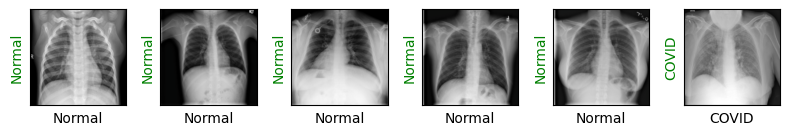

In [ ]:
images, labels = next(iter(dl_train)) #Fetch the next batch of images
show_images(images, labels, labels)

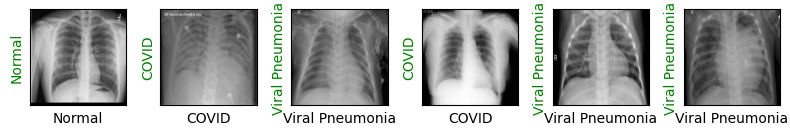

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True) #resnet18 is a small CNN that we can train quickly giving us decent results


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Changing the last fc to 3 output features

resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5) #To find optimum learning rate 1. Trial/Error 2. Hyperparameter search

In [ ]:
def show_preds():
    resnet18.eval()  #Setting the model to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

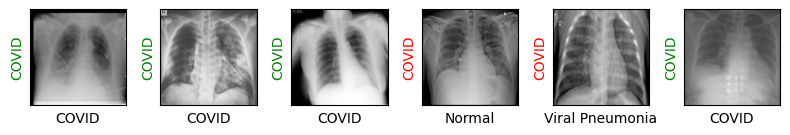

In [ ]:
show_preds()


In [ ]:
!pip install matplotlib scikit-learn


In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.  #Not computing val_loss since we'll be evaluating the model multiple times within one epoch

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            #Once we get the loss we need to take a gradient step
            loss.backward() #Back propogation
            optimizer.step() #Completes the gradient step by updating all the parameter values(We are using all parameters)
            train_loss += loss.item() #Loss is a tensor which can't be added to train_loss so .item() converts it to float

            #Evaluating the model every 20th step
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) # 1 corresponds to the values and ) corresponds to the no of examples
                    accuracy += sum((preds == labels).numpy()) #adding correct preds to acc

                val_loss /= (val_step + 1) # 15 test batches so this logic gives the value for each step
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.1981, Accuracy: 0.9333


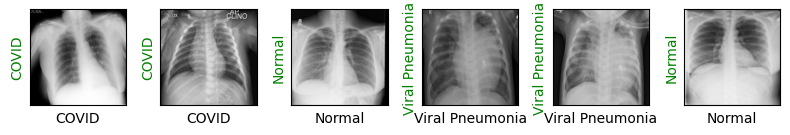

Evaluating at step 20
Validation Loss: 0.1923, Accuracy: 0.9333


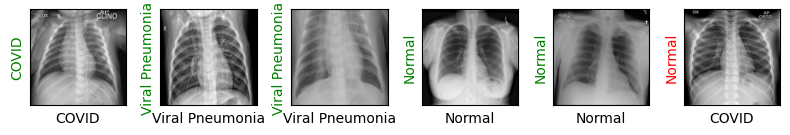

Evaluating at step 40
Validation Loss: 0.2247, Accuracy: 0.9222


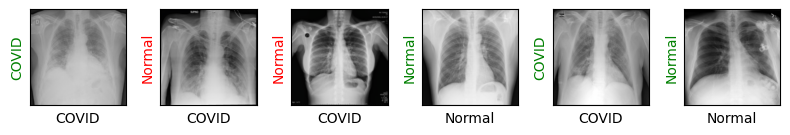

Evaluating at step 60
Validation Loss: 0.1661, Accuracy: 0.9444


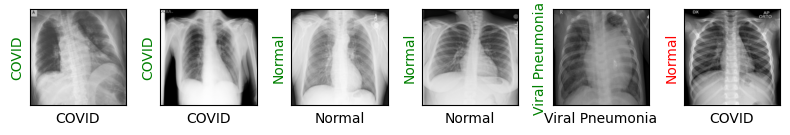

Evaluating at step 80
Validation Loss: 0.1565, Accuracy: 0.9444


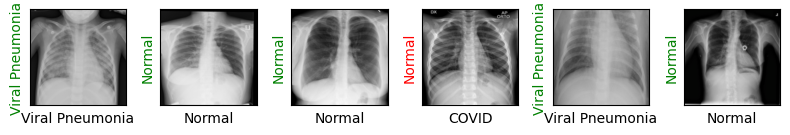

Evaluating at step 100
Validation Loss: 0.1970, Accuracy: 0.9222


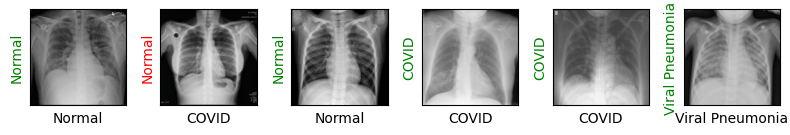

Evaluating at step 120
Validation Loss: 0.2451, Accuracy: 0.9222


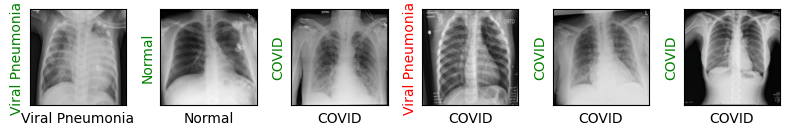

Evaluating at step 140
Validation Loss: 0.2439, Accuracy: 0.9000


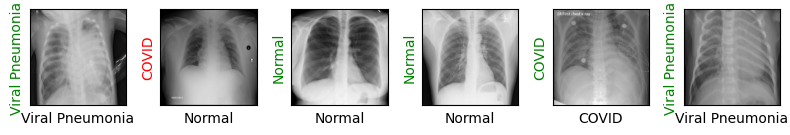

Evaluating at step 160
Validation Loss: 0.2030, Accuracy: 0.9000


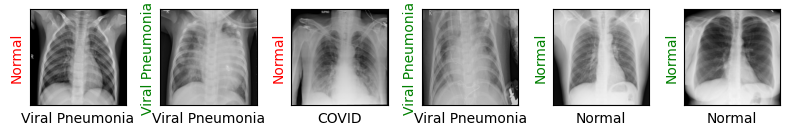

Evaluating at step 180
Validation Loss: 0.2496, Accuracy: 0.9111


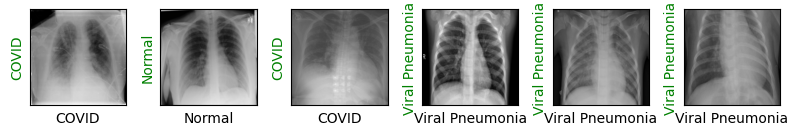

Evaluating at step 200
Validation Loss: 0.1688, Accuracy: 0.9444


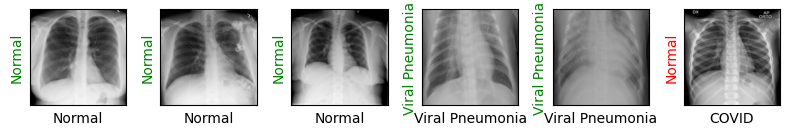

Evaluating at step 220
Validation Loss: 0.1842, Accuracy: 0.9222


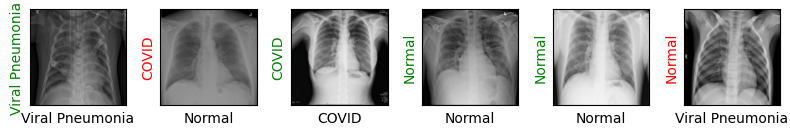

Evaluating at step 240
Validation Loss: 0.1858, Accuracy: 0.9222


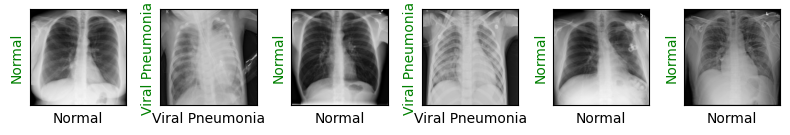

Evaluating at step 260
Validation Loss: 0.1747, Accuracy: 0.9444


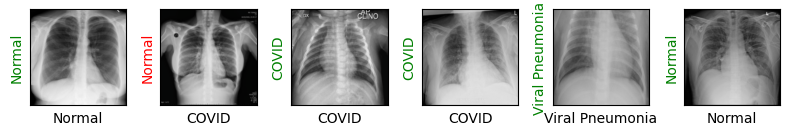

Evaluating at step 280
Validation Loss: 0.1720, Accuracy: 0.9444


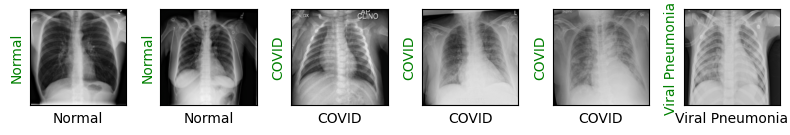

Evaluating at step 300
Validation Loss: 0.2382, Accuracy: 0.9222


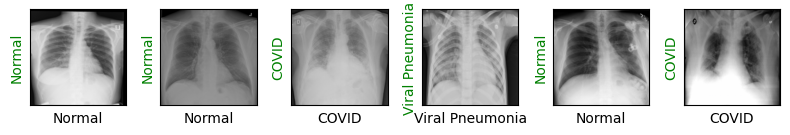

Evaluating at step 320
Validation Loss: 0.2211, Accuracy: 0.9111


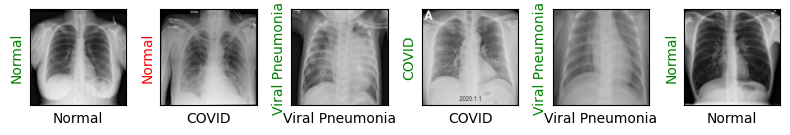

Evaluating at step 340
Validation Loss: 0.2755, Accuracy: 0.9111


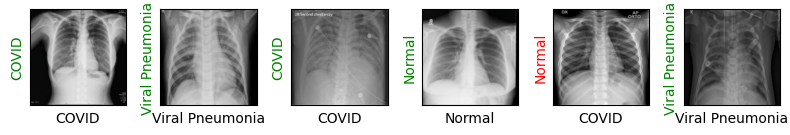

Evaluating at step 360
Validation Loss: 0.1757, Accuracy: 0.9556


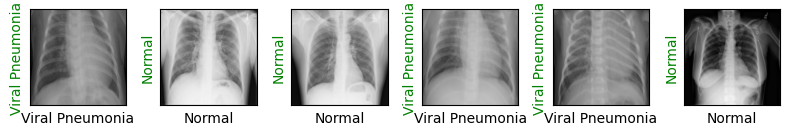

Performance condition satisfied, stopping..
CPU times: user 12min 39s, sys: 14.4 s, total: 12min 53s
Wall time: 12min 56s


In [ ]:
%%time

train(epochs=1)

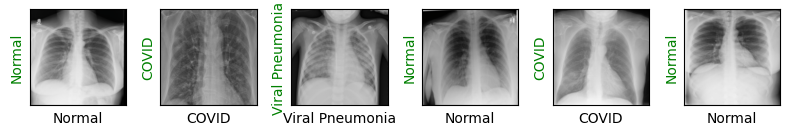

In [ ]:
show_preds()